# Code to Predict Change of Primary Care Physician

IMPORT LIBRARIES AND DATASETS

In [152]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [154]:
PCPChange_df = pd.read_csv('DataSet_PCP_Change.csv')
PCPChange_df = PCPChange_df[['outcome', 'distance','visit_count','tier','fqhc','pcp_lookback','family_assignment', 'kid','is_ped', 'same_gender', 'same_language', 'same_address']]
PCPChange_df['outcome'] = PCPChange_df['outcome'].astype('int')
PCPChange_df.head()

,outcome,distance,visit_count,tier,fqhc,pcp_lookback,family_assignment,kid,is_ped,same_gender,same_language,same_address
0,0,0.071912,0,2.0,0,0,0,0,0,1,0,0
1,0,0.448447,0,1.0,0,0,1,1,1,0,0,0
2,0,0.345793,0,1.0,0,1,0,0,0,1,0,0
3,0,1.857032,0,1.0,0,0,1,1,1,1,0,0
4,1,7.222060,0,1.0,0,0,1,1,0,0,0,0


Check for values in PCP dataset

In [156]:
PCPChange_df.isnull().any()

outcome              False
distance             False
visit_count          False
tier                  True
fqhc                 False
pcp_lookback         False
family_assignment    False
kid                  False
is_ped               False
same_gender          False
same_language        False
same_address         False
dtype: bool

In [168]:
def impute_tier(tier):
    if pd.isnull(tier):
        return 1
    else:
        return tier

In [188]:
PCPChange_df['tier'] = PCPChange_df['tier'].apply(impute_tier)
PCPChange_df['tier'] = PCPChange_df['tier'].astype(int)

Tier doesn't have any null value now.

In [189]:
PCPChange_df.isnull().any()

outcome              False
distance             False
visit_count          False
tier                 False
fqhc                 False
pcp_lookback         False
family_assignment    False
kid                  False
is_ped               False
same_gender          False
same_language        False
same_address         False
dtype: bool

In [190]:
PCPChange_df.head()

,outcome,distance,visit_count,tier,fqhc,pcp_lookback,family_assignment,kid,is_ped,same_gender,same_language,same_address
0,0,0.071912,0,2,0,0,0,0,0,1,0,0
1,0,0.448447,0,1,0,0,1,1,1,0,0,0
2,0,0.345793,0,1,0,1,0,0,0,1,0,0
3,0,1.857032,0,1,0,0,1,1,1,1,0,0
4,1,7.222060,0,1,0,0,1,1,0,0,0,0


In [191]:
PCPChange_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3130 entries, 0 to 3129
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   outcome            3130 non-null   int32  
 1   distance           3130 non-null   float64
 2   visit_count        3130 non-null   int64  
 3   tier               3130 non-null   int32  
 4   fqhc               3130 non-null   int64  
 5   pcp_lookback       3130 non-null   int64  
 6   family_assignment  3130 non-null   int64  
 7   kid                3130 non-null   int64  
 8   is_ped             3130 non-null   int64  
 9   same_gender        3130 non-null   int64  
 10  same_language      3130 non-null   int64  
 11  same_address       3130 non-null   int64  
dtypes: float64(1), int32(2), int64(9)
memory usage: 269.1 KB


Let's see if we have any missing data, luckily we don't!

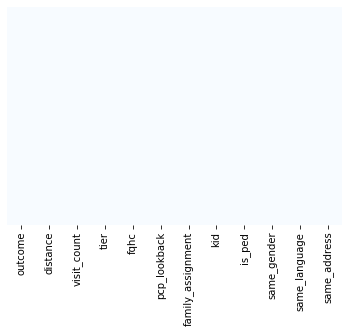

In [192]:
sns.heatmap(PCPChange_df.isnull(), yticklabels = False, cbar = False, cmap="Blues")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000280434D6D88>]],
      dtype=object)

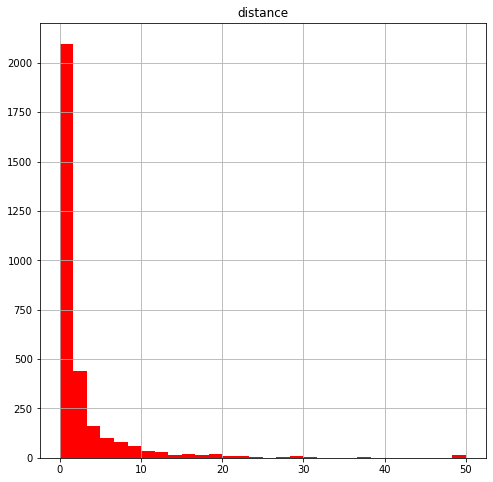

In [193]:
PCPChange_df[['distance']].hist(bins = 30, figsize = (8,8), color = 'r')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028043723508>]],
      dtype=object)

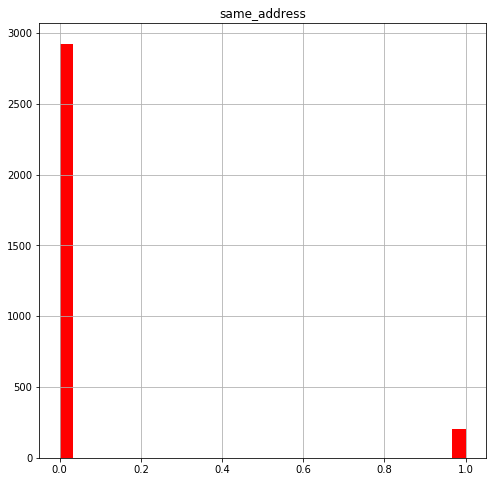

In [194]:
PCPChange_df[['same_address']].hist(bins = 30, figsize = (8,8), color = 'r')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000280437B6AC8>]],
      dtype=object)

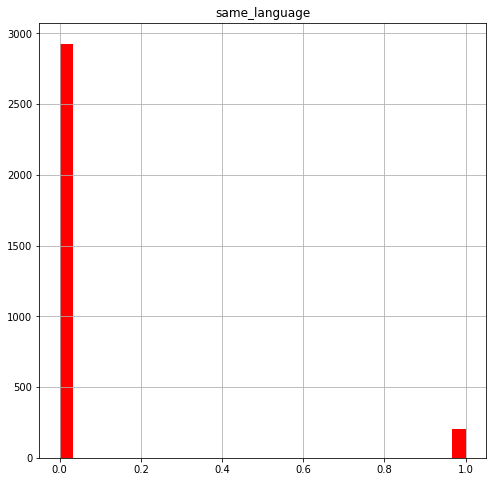

In [195]:
PCPChange_df[['same_language']].hist(bins = 30, figsize = (8,8), color = 'r')

Let's see how many members changed PCP

In [196]:
PCP_Changed        = PCPChange_df[PCPChange_df['outcome'] == 1]
PCP_Same      = PCPChange_df[PCPChange_df['outcome'] == 0]

Count the number of individuals who changed and did not change PCP 

In [197]:
print("Total =", len(PCPChange_df))

print("Number of individuals who changed PCP =", len(PCP_Changed))
print("Percentage of individuals who changed PCP =", 1.*len(PCP_Changed)/len(PCPChange_df)*100.0, "%")
 
print("Number of members who did not change PCP =", len(PCP_Same))
print("Percentage of members who did not change PCP =", 1.*len(PCP_Same)/len(PCPChange_df)*100.0, "%")

Total = 3130
Number of individuals who changed PCP = 127
Percentage of individuals who changed PCP = 4.057507987220448 %
Number of members who did not change PCP = 3003
Percentage of members who did not change PCP = 95.94249201277955 %


In [198]:
PCP_Changed.describe()

,outcome,distance,visit_count,tier,fqhc,pcp_lookback,family_assignment,kid,is_ped,same_gender,same_language,same_address
count,127.0,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000
mean,1.0,5.266218,2.055118,1.866142,0.125984,0.228346,0.370079,0.488189,0.393701,0.511811,0.023622,0.165354
std,0.0,8.054337,3.671657,1.064299,0.333146,0.421429,0.484738,0.501840,0.490505,0.501840,0.152470,0.372971
min,1.0,0.047814,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.745982,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,2.102238,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.0,6.434954,3.000000,2.500000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,1.0,50.000000,21.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Let's compare the mean and std of the individuals who changed PCP and who didn't

Mean of Distance between member and provider in miles is more for the member who changed PCP
Mean of Number of claims between member and provider is more for the member who changed PCP
Mean of PCP_Lookback is less when member changed PCP
Members having same language as PCP are less likely to change PCP than members with different PCP
Members having same address as PCP are less likely to change PCP

In [199]:
PCP_Same.describe()

,outcome,distance,visit_count,tier,fqhc,pcp_lookback,family_assignment,kid,is_ped,same_gender,same_language,same_address
count,3003.0,3003.000000,3003.000000,3003.00000,3003.000000,3003.000000,3003.000000,3003.000000,3003.000000,3003.000000,3003.00000,3003.000000
mean,0.0,2.749683,1.032634,1.81019,0.195138,0.451215,0.340659,0.372294,0.392274,0.511822,0.06660,0.061272
std,0.0,5.661017,3.131304,0.98824,0.396373,0.497697,0.474010,0.483497,0.488339,0.499943,0.24937,0.239869
min,0.0,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.0,0.460345,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,0.0,0.987850,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000
75%,0.0,2.062701,0.000000,2.00000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.00000,0.000000
max,0.0,50.000000,36.000000,4.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


# CREATE TESTING AND TRAINING DATASET & PERFORM DATA CLEANING

In [200]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(PCPChange_df)

TRAIN AND EVALUATE A LOGISTIC REGRESSION CLASSIFIER

In [201]:

from sklearn.model_selection import train_test_split
X = PCPChange_df[['distance','visit_count','fqhc','pcp_lookback','kid','is_ped','same_gender','same_language','same_address']]
y = PCPChange_df[['outcome']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [202]:
X_train.shape

(2347, 9)

In [203]:
X_test.shape

(783, 9)

In [204]:
#LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [205]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Accuracy with Logistic Regression classifier

In [206]:
from sklearn.metrics import confusion_matrix, classification_report

print("Accuracy {} %".format( 100 * accuracy_score(y_pred, y_test)))

Accuracy 96.42401021711366 %


Confusion Matrix for Logistic Regression

array([[754,  27],
       [  1,   1]], dtype=int64)

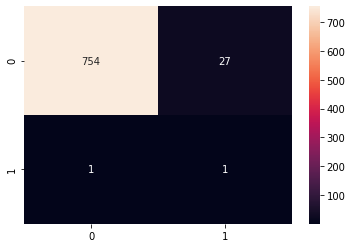

In [207]:
cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, annot=True, fmt='d')
cm

In [208]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       755
           1       0.50      0.04      0.07        28

    accuracy                           0.96       783
   macro avg       0.73      0.52      0.52       783
weighted avg       0.95      0.96      0.95       783



TRAIN AND EVALUATE A RANDOM FOREST CLASSIFIER

In [209]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [210]:
y_pred = model.predict(X_test)

Testing Set Performance

array([[743,  28],
       [ 12,   0]], dtype=int64)

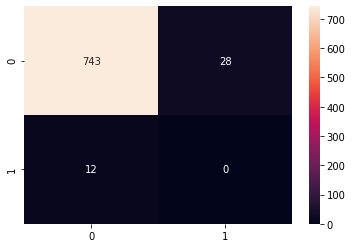

In [211]:
cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, annot=True, fmt='d')
cm

In [212]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       755
           1       0.00      0.00      0.00        28

    accuracy                           0.95       783
   macro avg       0.48      0.49      0.49       783
weighted avg       0.93      0.95      0.94       783



In [213]:
print("Accuracy {} %".format( 100 * accuracy_score(y_pred, y_test)))

Accuracy 94.89144316730524 %


Train and Test using Decision Tree

In [214]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [215]:
y_pred = model.predict(X_test)

Testing Set Performance

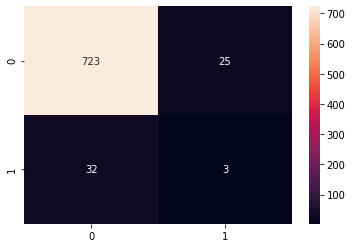

array([[723,  25],
       [ 32,   3]], dtype=int64)

In [216]:
cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()
cm

In [217]:
print("Accuracy {} %".format( 100 * accuracy_score(y_pred, y_test)))

Accuracy 92.72030651340997 %
